In [1]:
import numpy as np
import pandas as pd
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
import seaborn as sns

import arviz as az
import scipy.stats as st

colors (#0072B2 , #009E73, and #D55E00) are part of the Okabe-Ito, specifically designed to be colorblind-friendly.

In [2]:
data = pd.read_csv("data/all_data.csv")
data

,code,block,trial,input_noise_magnitude,inpnoise_ascending,feedback,SoC,avg_dist_trialwise,InternalLC,ExternalLC,CESDR,CESDR_cat,negative_feedback,positive_feedback
0,1,1,1,2.0,1,positive,3,45.980288,3.5,1.5,31,1,0,1
1,1,1,2,2.0,1,negative,5,27.928305,3.5,1.5,31,1,1,0
2,1,1,3,2.0,1,positive,3,51.842082,3.5,1.5,31,1,0,1
3,1,1,4,2.0,1,negative,2,44.982707,3.5,1.5,31,1,1,0
4,1,1,5,2.0,1,positive,6,35.417424,3.5,1.5,31,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11515,9,8,26,2.0,4,positive,4,61.940248,4.5,2.5,11,0,0,1
11516,9,8,27,2.0,4,negative,3,61.907699,4.5,2.5,11,0,1,0
11517,9,8,28,2.0,4,negative,3,49.690419,4.5,2.5,11,0,1,0
11518,9,8,29,2.0,4,positive,4,66.260599,4.5,2.5,11,0,0,1


### Model 1: predicting performance (average distance in pixel)

Fixed effects:
                               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)                   3.259e+00  3.583e-02  5.232e+01  90.972  < 2e-16 ***
input_noise_magnitude2        5.844e-01  2.565e-02  6.673e+01  22.786  < 2e-16 ***
block                        -2.058e-02  1.580e-03  1.147e+04 -13.028  < 2e-16 ***
input_noise_magnitude2:block  1.116e-02  2.219e-03  1.147e+04   5.029 5.01e-07 ***

### Plotting Model 1:

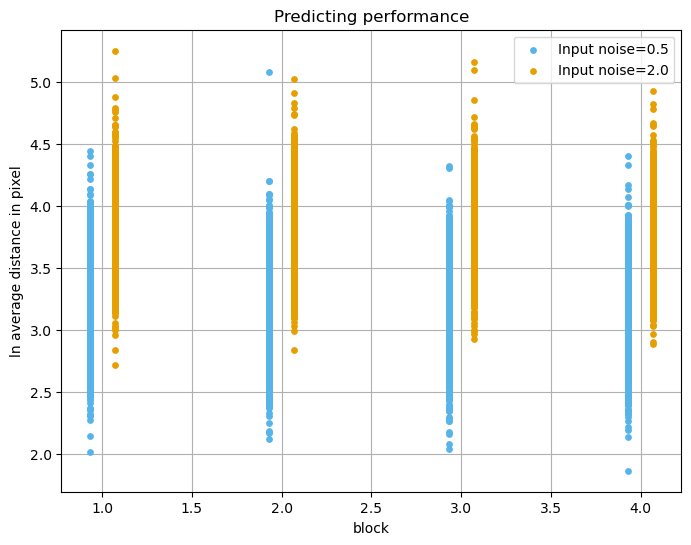

In [19]:
# Separate data based on input_noise_magnitude
data_1 = data[data["input_noise_magnitude"] == 0.5]
data_2 = data[data["input_noise_magnitude"] == 2.0]

# Define linear model parameters (replace with your actual intercept and slope)
intercept_1, slope_1 = 3.259, -0.02058
intercept_2, slope_2 = 3.259+0.5844, -0.02058*(0.01116)
# tranformed
#intercept_1, slope_1 = np.exp(3.259), -np.exp(0.02058)
#intercept_2, slope_2 = np.exp(3.259+0.5844), -np.exp(0.02058*0.01116)


plt.rcParams['axes.axisbelow'] = True
plt.figure(figsize=(8, 6))
plt.grid(True)

# scattered data points
plt.scatter(data_1["inpnoise_ascending"] - 0.07, np.log(data_1["avg_dist_trialwise"]), s=15, color="#56B4E9", label=f"Input noise=0.5")
plt.scatter(data_2["inpnoise_ascending"] + 0.07, np.log(data_2["avg_dist_trialwise"]), s=15, color="#E69F00", label=f"Input noise=2.0")

# linear models
x_range_1 = np.linspace(data_1["inpnoise_ascending"].min(), data_1["inpnoise_ascending"].max(), 100)
y_range_1 = intercept_1 + slope_1 * x_range_1
#plt.plot(x_range_1, y_range_1, color="#56B4E9", linestyle='-')  # np.exp to reach data point scale

x_range_2 = np.linspace(data_2["inpnoise_ascending"].min(), data_2["inpnoise_ascending"].max(), 100)
y_range_2 = intercept_2 + slope_2 * x_range_2
#plt.plot(x_range_2, y_range_2, color="#E69F00", linestyle='-')  # np.exp to reach data point scale


#for code in [data_1.code]:
    


# Labeling
plt.xlabel("block")
plt.ylabel("ln average distance in pixel")
#plt.ylabel(r'$log_{e}$ average distance in pixel')
plt.legend()
plt.title("Predicting performance")

#plt.savefig("model1_scatter.svg", dpi=2000)

plt.show()

In [12]:
data.columns

Index(['code', 'block', 'trial', 'input_noise_magnitude', 'inpnoise_ascending',
       'feedback', 'SoC', 'avg_dist_trialwise', 'InternalLC', 'ExternalLC',
       'CESDR', 'CESDR_cat', 'negative_feedback', 'positive_feedback'],
      dtype='object')

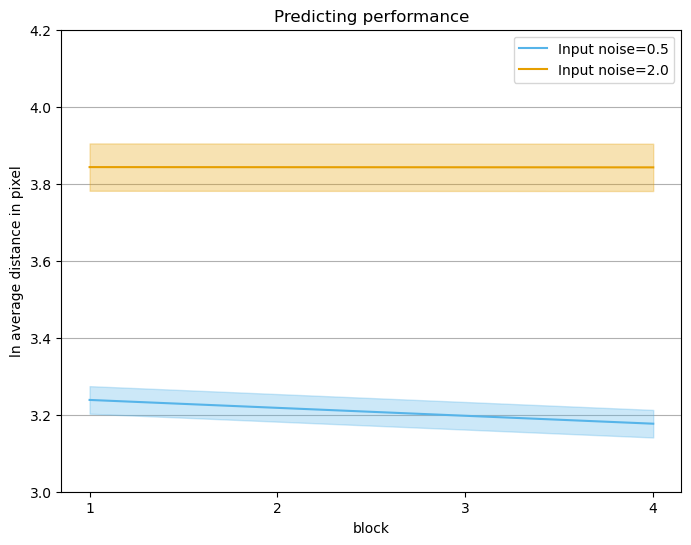

In [27]:
# Separate data based on input_noise_magnitude
#data_1 = data[data["input_noise_magnitude"] == 0.5]
#data_2 = data[data["input_noise_magnitude"] == 2.0]
# only used for ranges, not for actual data


# Define linear model parameters (replace with your actual intercept and slope)
intercept_1, slope_1, ci_1 = 3.259, -0.02058, 0.0358
intercept_2, slope_2, ci_2 = 3.259+0.5844, -0.02058*(0.01116), 0.0257


plt.rcParams['axes.axisbelow'] = True
plt.figure(figsize=(8, 6))
#plt.grid(True)
plt.grid(axis='y')


# linear models

# input noise:0.5
x_range_1 = np.linspace(1, 4, 100)
y_range_1 = intercept_1 + slope_1 * x_range_1
plt.plot(x_range_1, y_range_1, color="#56B4E9", linestyle='-', label=f"Input noise=0.5")
# CI
plt.fill_between(x_range_1, y_range_1-ci_1, y_range_1+ci_1, color="#56B4E9", alpha=.3)



# input noise:2.0
x_range_2 = np.linspace(1, 4, 100)
y_range_2 = intercept_2 + slope_2 * x_range_2
plt.plot(x_range_2, y_range_2, color="#E69F00", linestyle='-', label=f"Input noise=2.0")
# CI
plt.fill_between(x_range_2, y_range_2-ci_1-ci_2, y_range_2+ci_1+ci_2, color="#E69F00", alpha=.3)


# Labeling
plt.xlabel("block")
plt.xticks([1, 2, 3, 4])
plt.ylabel("ln average distance in pixel")
plt.ylim([3.0, 4.2])
plt.legend()
plt.title("Predicting performance")

#plt.savefig("performance_model.svg", dpi=2000)

plt.show()

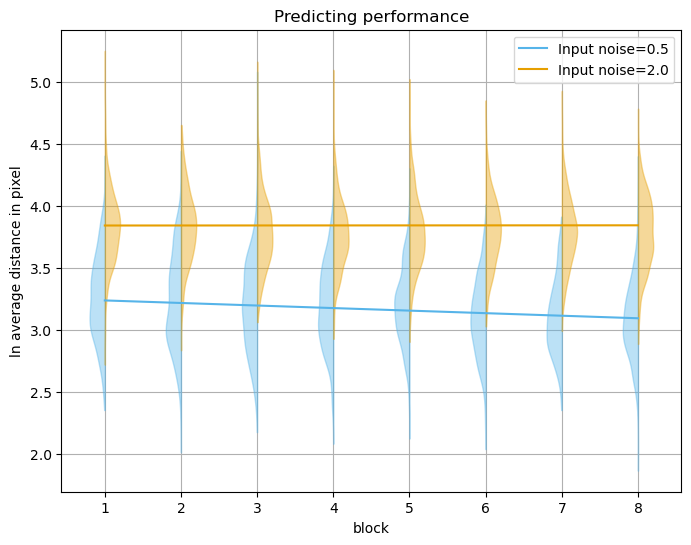

In [8]:
# Separate data based on input_noise_magnitude
data_1 = data[data["input_noise_magnitude"] == 0.5]
data_2 = data[data["input_noise_magnitude"] == 2.0]

# Define linear model parameters (replace with your actual intercept and slope)
intercept_1, slope_1 = 3.259, -0.02058
intercept_2, slope_2 = 3.259+0.5844, -0.02058*(-0.01116)
# tranformed
#intercept_1, slope_1 = np.exp(3.259), -np.exp(0.02058)
#intercept_2, slope_2 = np.exp(3.259+0.5844), -np.exp(0.02058*0.01116)

plt.rcParams['axes.axisbelow'] = True
plt.figure(figsize=(8, 6))
plt.grid(True)

# scattered data points
#plt.scatter(data_1["block"] - 0.07, np.log(data_1["avg_dist_trialwise"]), s=15, color="#0072B2", label=f"Input noise=0.5")
#plt.scatter(data_2["block"] + 0.07, np.log(data_2["avg_dist_trialwise"]), s=15, color="#D55E00", label=f"Input noise=2.0")

# linear models
x_range_1 = np.linspace(data_1["block"].min(), data_1["block"].max(), 100)
y_range_1 = intercept_1 + slope_1 * x_range_1
plt.plot(x_range_1, y_range_1, color="#56B4E9", linestyle='-', label=f"Input noise=0.5")  # np.exp to reach data point scale

x_range_2 = np.linspace(data_2["block"].min(), data_2["block"].max(), 100)
y_range_2 = intercept_2 + slope_2 * x_range_2
plt.plot(x_range_2, y_range_2, color="#E69F00", linestyle='-', label=f"Input noise=2.0")  # np.exp to reach data point scale


# vertical density distributions for each block value
blocks = sorted(data["block"].unique())
for block in blocks:
    block_data_1 = data_1[data_1["block"] == block]
    block_data_2 = data_2[data_2["block"] == block]

    if not block_data_1.empty:
        kde_1 = gaussian_kde(np.log(block_data_1["avg_dist_trialwise"]))
        y_vals_1 = np.linspace(np.log(block_data_1["avg_dist_trialwise"]).min(), np.log(block_data_1["avg_dist_trialwise"]).max(), 100)
        density_1 = kde_1(y_vals_1)
        plt.fill_betweenx(y_vals_1, block - density_1 / density_1.max() * 0.2, block, color='#56B4E9', alpha=0.4)
        #plt.fill_betweenx(y_vals_1, block, block + density_1 / density_1.max() * 0.2, color='#56B4E9', alpha=0.4)


    if not block_data_2.empty:
        kde_2 = gaussian_kde(np.log(block_data_2["avg_dist_trialwise"]))
        y_vals_2 = np.linspace(np.log(block_data_2["avg_dist_trialwise"]).min(), np.log(block_data_2["avg_dist_trialwise"]).max(), 100)
        density_2 = kde_2(y_vals_2)
        plt.fill_betweenx(y_vals_2, block, block + density_2 / density_2.max() * 0.2, color='#E69F00', alpha=0.4)

# Labeling
plt.xlabel("block")
plt.ylabel("ln average distance in pixel")
plt.legend()
plt.title("Predicting performance")

#plt.savefig("model1_pdf.svg", dpi=2000)

plt.show()

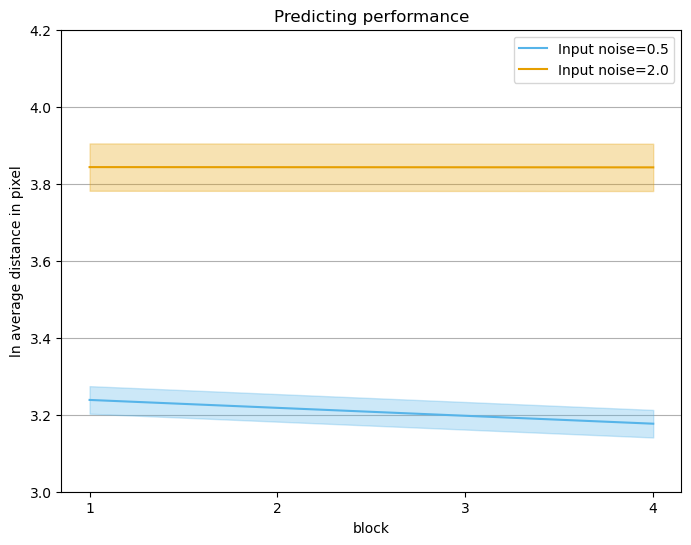

In [34]:
# Separate data based on input_noise_magnitude
#data_1 = data[data["input_noise_magnitude"] == 0.5]
#data_2 = data[data["input_noise_magnitude"] == 2.0]
# only used for ranges, not for actual data


# Define linear model parameters (replace with your actual intercept and slope)
intercept_1, slope_1, ci_1 = 3.259, -0.02058, 0.0358
intercept_2, slope_2, ci_2 = 3.259+0.5844, -0.02058*(0.01116), 0.0257


plt.rcParams['axes.axisbelow'] = True
plt.figure(figsize=(8, 6))
#plt.grid(True)
plt.grid(axis='y')


# linear models

# input noise:0.5
x_range_1 = np.linspace(1, 4, 100)
y_range_1 = intercept_1 + slope_1 * x_range_1
plt.plot(x_range_1, y_range_1, color="#56B4E9", linestyle='-', label=f"Input noise=0.5")
# CI
plt.fill_between(x_range_1, y_range_1-ci_1, y_range_1+ci_1, color="#56B4E9", alpha=.3)



# input noise:2.0
x_range_2 = np.linspace(1, 4, 100)
y_range_2 = intercept_2 + slope_2 * x_range_2
plt.plot(x_range_2, y_range_2, color="#E69F00", linestyle='-', label=f"Input noise=2.0")
# CI
plt.fill_between(x_range_2, y_range_2-ci_1-ci_2, y_range_2+ci_1+ci_2, color="#E69F00", alpha=.3)


# Labeling
plt.xlabel("block")
plt.xticks([1, 2, 3, 4])
plt.ylabel("ln average distance in pixel")
plt.ylim([3.0, 4.2])
plt.legend()
plt.title("Predicting performance")

plt.savefig("performance_model.svg", dpi=2000)

plt.show()

Fixed effects:
                               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)                   2.210e+00  7.613e-02  5.672e+01  29.026  < 2e-16 ***
feedbackpositive              3.680e-02  5.883e-03  1.142e+04   6.256 4.09e-10 ***
feedbacknegative             -8.148e-02  8.749e-03  1.142e+04  -9.314  < 2e-16 ***
input_noise_magnitude2       -2.820e-01  4.549e-02  5.446e+01  -6.199 7.92e-08 ***
ExternalLC                    1.017e-01  3.114e-02  4.800e+01   3.265  0.00202 ** 
CESDR                        -5.459e-04  2.461e-03  4.852e+01  -0.222  0.82536    
block                         6.915e-03  1.616e-03  1.146e+04   4.279 1.89e-05 ***
avg_dist_trialwise           -8.984e-03  2.271e-04  1.147e+04 -39.565  < 2e-16 ***
CESDR:negative_feedback       2.150e-03  5.443e-04  1.142e+04   3.950 7.86e-05 ***
input_noise_magnitude2:block -1.927e-02  2.263e-03  1.145e+04  -8.515  < 2e-16 ***

Effects to plot: SoC ~ CESDr * negative feedback

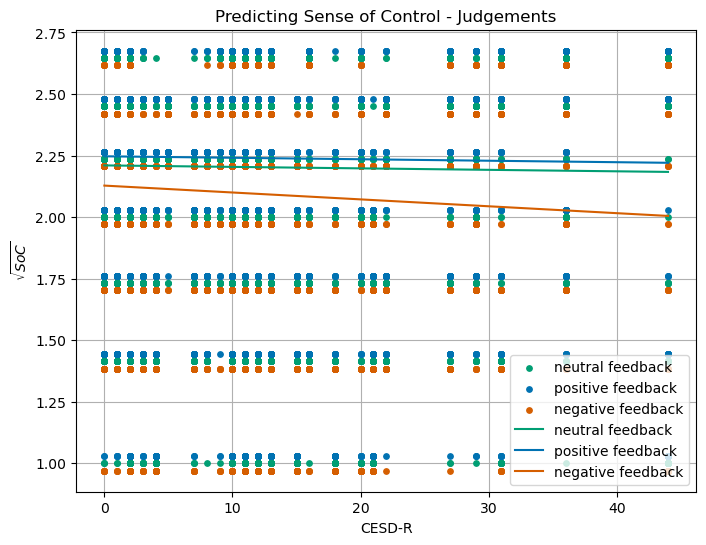

In [76]:
# Separate data based on input_noise_magnitude
data_neutral = data[data["feedback"] == "neutral"]
data_positive = data[data["feedback"] == "positive"]
data_negative = data[data["feedback"] == "negative"]

# Define linear model parameters (replace with your actual intercept and slope)
intercept_neutral, slope_neutral = 2.210, -0.0006
intercept_positive, slope_positive = 2.210+0.037, -0.0006
intercept_negative, slope_negative = 2.210-0.082, -0.0006-0.0022


plt.rcParams['axes.axisbelow'] = True
plt.figure(figsize=(8, 6))
plt.grid(True)

# scattered data points
plt.scatter(data_neutral["CESDR"], np.sqrt(data_neutral["SoC"]), s=15, color="#009E73", label=f"neutral feedback")
plt.scatter(data_positive["CESDR"], np.sqrt(data_positive["SoC"])+0.03, s=15, color="#0072B2", label=f"positive feedback")
plt.scatter(data_negative["CESDR"], np.sqrt(data_negative["SoC"])-0.03, s=15, color="#D55E00", label=f"negative feedback")

# linear models

# neutral
x_range_neutral = np.linspace(data_neutral["CESDR"].min(), data_neutral["CESDR"].max(), 100)
y_range_neutral = intercept_neutral + slope_neutral * x_range_neutral
plt.plot(x_range_neutral, y_range_neutral, color="#009E73", linestyle='-', label=f"neutral feedback")

# positive
x_range_positive = np.linspace(data_positive["CESDR"].min(), data_positive["CESDR"].max(), 100)
y_range_positive = intercept_positive + slope_positive * x_range_positive
plt.plot(x_range_positive, y_range_positive, color="#0072B2", linestyle='-', label=f"positive feedback")

# negative
x_range_negative = np.linspace(data_negative["CESDR"].min(), data_negative["CESDR"].max(), 100)
y_range_negative = intercept_negative + slope_negative * x_range_negative
plt.plot(x_range_negative, y_range_negative, color="#D55E00", linestyle='-', label=f"negative feedback")

# Labeling
plt.xlabel("CESD-R")
plt.ylabel(r'$\sqrt{SoC}$')
plt.legend()
plt.title("Predicting Sense of Control - Judgements")

plt.show()

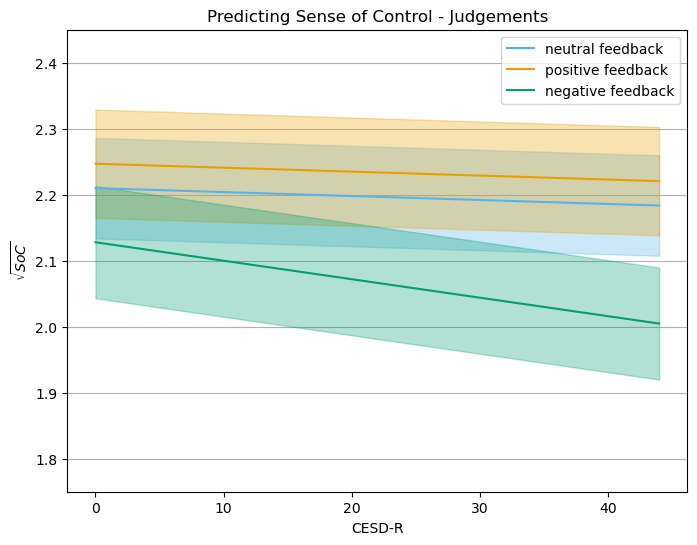

In [7]:
# Separate data based on input_noise_magnitude
data_neutral = data[data["feedback"] == "neutral"]
data_positive = data[data["feedback"] == "positive"]
data_negative = data[data["feedback"] == "negative"]

# Define linear model parameters (replace with your actual intercept and slope)
intercept_neutral, slope_neutral, ci_neutral = 2.210, -0.0006, 0.0761
intercept_positive, slope_positive, ci_positive = 2.210+0.037, -0.0006, 0.0059
intercept_negative, slope_negative, ci_negative = 2.210-0.082, -0.0006-0.0022, 0.0088


plt.rcParams['axes.axisbelow'] = True
plt.figure(figsize=(8, 6))
#plt.grid(True)
plt.grid(axis='y')

# linear models

# neutral
x_range_neutral = np.linspace(data_neutral["CESDR"].min(), data_neutral["CESDR"].max(), 100)
y_range_neutral = intercept_neutral + slope_neutral * x_range_neutral
plt.plot(x_range_neutral, y_range_neutral, color="#56B4E9", linestyle='-', label=f"neutral feedback")
# CI
plt.fill_between(x_range_neutral, y_range_neutral-ci_neutral, y_range_neutral+ci_neutral, color="#56B4E9", alpha=.3)

# positive
x_range_positive = np.linspace(data_positive["CESDR"].min(), data_positive["CESDR"].max(), 100)
y_range_positive = intercept_positive + slope_positive * x_range_positive
plt.plot(x_range_positive, y_range_positive, color="#E69F00", linestyle='-', label=f"positive feedback")
# CI
plt.fill_between(x_range_positive, y_range_positive-ci_neutral-ci_positive, y_range_positive+ci_neutral+ci_positive, color="#E69F00", alpha=.3)

# negative
x_range_negative = np.linspace(data_negative["CESDR"].min(), data_negative["CESDR"].max(), 100)
y_range_negative = intercept_negative + slope_negative * x_range_negative
plt.plot(x_range_negative, y_range_negative, color="#009E73", linestyle='-', label=f"negative feedback")
# CI
plt.fill_between(x_range_negative, y_range_negative-ci_neutral-ci_negative, y_range_negative+ci_neutral+ci_negative, color="#009E73", alpha=.3)


#009E73 # green
#E69F00 # orange
#56B4E9 # blue


# Labeling
plt.xlabel("CESD-R")
plt.ylim([1.75, 2.45])
plt.ylabel(r'$\sqrt{SoC}$')
plt.legend()
plt.title("Predicting Sense of Control - Judgements")


#plt.savefig("soc_model_feedback_cesdr.svg", dpi=2000)

plt.show()

Effects to plot: SoC ~ input_noise:2.0 * block

Fixed effects:
                               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)                   2.210e+00  7.613e-02  5.672e+01  29.026  < 2e-16 ***
feedbackpositive              3.680e-02  5.883e-03  1.142e+04   6.256 4.09e-10 ***
feedbacknegative             -8.148e-02  8.749e-03  1.142e+04  -9.314  < 2e-16 ***
input_noise_magnitude2       -2.820e-01  4.549e-02  5.446e+01  -6.199 7.92e-08 ***
ExternalLC                    1.017e-01  3.114e-02  4.800e+01   3.265  0.00202 ** 
CESDR                        -5.459e-04  2.461e-03  4.852e+01  -0.222  0.82536    
block                         6.915e-03  1.616e-03  1.146e+04   4.279 1.89e-05 ***
avg_dist_trialwise           -8.984e-03  2.271e-04  1.147e+04 -39.565  < 2e-16 ***
CESDR:negative_feedback       2.150e-03  5.443e-04  1.142e+04   3.950 7.86e-05 ***
input_noise_magnitude2:block -1.927e-02  2.263e-03  1.145e+04  -8.515  < 2e-16 ***

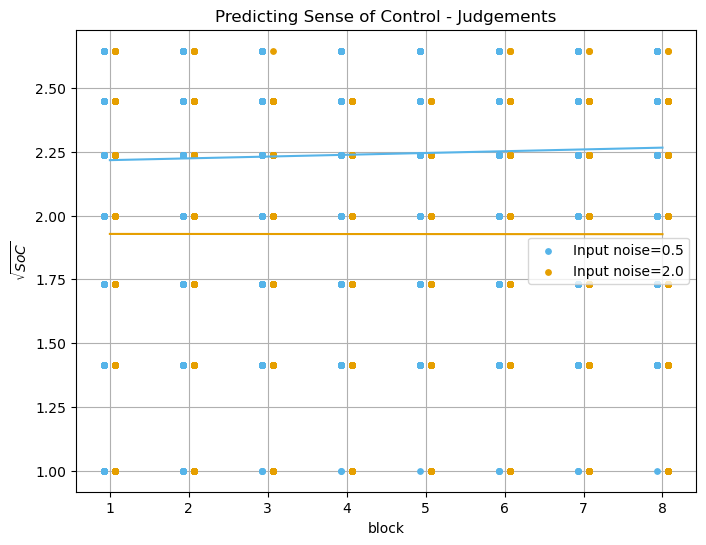

In [6]:
# Separate data based on input_noise_magnitude
data_1 = data[data["input_noise_magnitude"] == 0.5]
data_2 = data[data["input_noise_magnitude"] == 2.0]

# Define linear model parameters (replace with your actual intercept and slope)
intercept_1, slope_1 = 2.21, 0.007
intercept_2, slope_2 = 2.21-0.282, 0.007*(-0.0197)


plt.rcParams['axes.axisbelow'] = True
plt.figure(figsize=(8, 6))
plt.grid(True)

# scattered data points
plt.scatter(data_1["block"] - 0.07, np.sqrt(data_1["SoC"]), s=15, color="#56B4E9", label=f"Input noise=0.5")
plt.scatter(data_2["block"] + 0.07, np.sqrt(data_2["SoC"]), s=15, color="#E69F00", label=f"Input noise=2.0")

# linear models
x_range_1 = np.linspace(data_1["block"].min(), data_1["block"].max(), 100)
y_range_1 = intercept_1 + slope_1 * x_range_1
plt.plot(x_range_1, y_range_1, color="#56B4E9", linestyle='-')  # np.exp to reach data point scale

x_range_2 = np.linspace(data_2["block"].min(), data_2["block"].max(), 100)
y_range_2 = intercept_2 + slope_2 * x_range_2
plt.plot(x_range_2, y_range_2, color="#E69F00", linestyle='-')  # np.exp to reach data point scale

# Labeling
plt.xlabel("block")
plt.ylabel(r'$\sqrt{SoC}$')
plt.legend()
plt.title("Predicting Sense of Control - Judgements")

plt.show()

ISSUE: scatter hides data points, because data points are drawn atop each other.

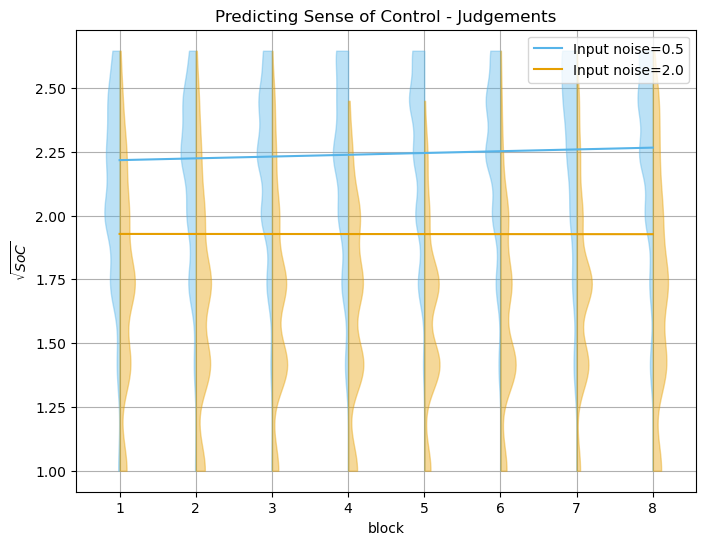

In [43]:
# Separate data based on input_noise_magnitude
data_1 = data[data["input_noise_magnitude"] == 0.5]
data_2 = data[data["input_noise_magnitude"] == 2.0]

# Define linear model parameters (replace with your actual intercept and slope)
intercept_1, slope_1 = 2.21, 0.007
intercept_2, slope_2 = 2.21-0.282, 0.007*(-0.0197)


plt.rcParams['axes.axisbelow'] = True
plt.figure(figsize=(8, 6))
plt.grid(True)


# linear models
x_range_1 = np.linspace(data_1["block"].min(), data_1["block"].max(), 100)
y_range_1 = intercept_1 + slope_1 * x_range_1
plt.plot(x_range_1, y_range_1, color="#56B4E9", linestyle='-', label=f"Input noise=0.5")  # np.exp to reach data point scale

x_range_2 = np.linspace(data_2["block"].min(), data_2["block"].max(), 100)
y_range_2 = intercept_2 + slope_2 * x_range_2
plt.plot(x_range_2, y_range_2, color="#E69F00", linestyle='-', label=f"Input noise=2.0")  # np.exp to reach data point scale

# vertical density distributions for each block value
blocks = sorted(data["block"].unique())
for block in blocks:
    block_data_1 = data_1[data_1["block"] == block]
    block_data_2 = data_2[data_2["block"] == block]

    if not block_data_1.empty:
        #plt.scatter(block, np.mean(np.sqrt(block_data_1["SoC"])), color="blue")
        kde_1 = gaussian_kde(np.sqrt(block_data_1["SoC"]))
        y_vals_1 = np.linspace(np.sqrt(block_data_1["SoC"]).min(), np.sqrt(block_data_1["SoC"]).max(), 100)
        density_1 = kde_1(y_vals_1)
        plt.fill_betweenx(y_vals_1, block - density_1 / density_1.max() * 0.2, block, color='#56B4E9', alpha=0.4)
        #plt.fill_betweenx(y_vals_1, block, block + density_1 / density_1.max() * 0.2, color='#56B4E9', alpha=0.4)

    if not block_data_2.empty:
        #plt.scatter(block, np.mean(np.sqrt(block_data_2["SoC"])), color="red")
        kde_2 = gaussian_kde(np.sqrt(block_data_2["SoC"]))
        y_vals_2 = np.linspace(np.sqrt(block_data_2["SoC"]).min(), np.sqrt(block_data_2["SoC"]).max(), 100)
        density_2 = kde_2(y_vals_2)
        plt.fill_betweenx(y_vals_2, block, block + density_2 / density_2.max() * 0.2, color='#E69F00', alpha=0.4)


# Labeling
plt.xlabel("block")
plt.ylabel(r'$\sqrt{SoC}$')
plt.legend()
plt.title("Predicting Sense of Control - Judgements")

#plt.savefig("model2_block_inputnoise.svg")

plt.show()

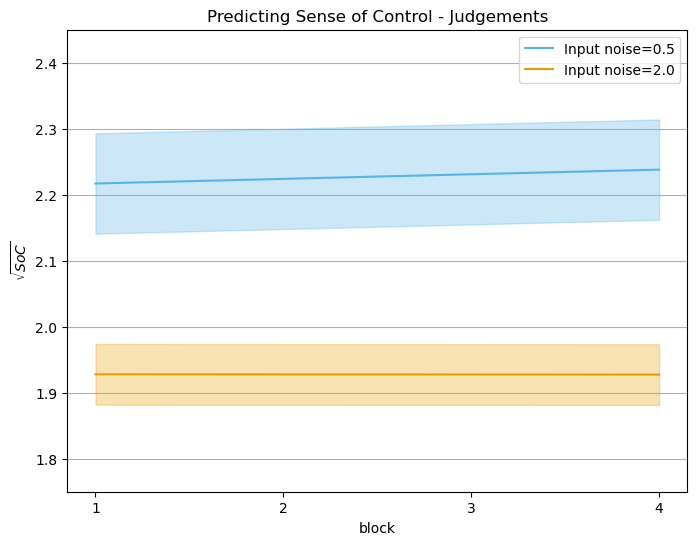

In [30]:
# separate data based on input_noise_magnitude
data_1 = data[data["input_noise_magnitude"] == 0.5]
data_2 = data[data["input_noise_magnitude"] == 2.0]

# linear model parameters
intercept_1, slope_1, ci_1 = 2.21, 0.007, 0.076
intercept_2, slope_2, ci_2 = 2.21-0.282, 0.007*(-0.0197), 0.046


plt.rcParams['axes.axisbelow'] = True
plt.figure(figsize=(8, 6))
#plt.grid(True)
plt.grid(axis='y')


# linear models

# input noise:0.5
x_range_1 = np.linspace(data_1["inpnoise_ascending"].min(), data_1["inpnoise_ascending"].max(), 100)
y_range_1 = intercept_1 + slope_1 * x_range_1
plt.plot(x_range_1, y_range_1, color="#56B4E9", linestyle='-', label=f"Input noise=0.5")  # np.exp to reach data point scale
# CI
plt.fill_between(x_range_1, y_range_1-ci_1, y_range_1+ci_1, color="#56B4E9", alpha=.3)


# input noise:2.0
x_range_2 = np.linspace(data_2["inpnoise_ascending"].min(), data_2["inpnoise_ascending"].max(), 100)
y_range_2 = intercept_2 + slope_2 * x_range_2
plt.plot(x_range_2, y_range_2, color="#E69F00", linestyle='-', label=f"Input noise=2.0")  # np.exp to reach data point scale
# CI
plt.fill_between(x_range_2, y_range_2-ci_2, y_range_2+ci_2, color="#E69F00", alpha=.3)


plt.xlabel("block")
plt.xticks([1, 2, 3, 4])
plt.ylim([1.75, 2.45])
plt.ylabel(r'$\sqrt{SoC}$')
plt.legend()
plt.title("Predicting Sense of Control - Judgements")

plt.savefig("soc_model_block_inputnoise.svg", dpi=2000)

plt.show()

# ___________________________________________________________________

# Revised model selection - interaction effects

In [3]:
pred_df = pd.read_csv("data/all_model_predictions.csv")
pred_df

,input_noise_magnitude,block,feedback,CESDR,ExternalLC,avg_dist_trialwise,code,fit,lower,upper
0,0.5,1,positive,11.895833,2.114583,35.96281,NaN,2.167019,2.107890,2.226149
1,2.0,1,positive,11.895833,2.114583,35.96281,NaN,1.865266,1.802951,1.927581
2,0.5,2,positive,11.895833,2.114583,35.96281,NaN,2.165924,2.107748,2.224101
3,2.0,2,positive,11.895833,2.114583,35.96281,NaN,1.844902,1.783454,1.906351
4,0.5,3,positive,11.895833,2.114583,35.96281,NaN,2.164829,2.107301,2.222358
5,2.0,3,positive,11.895833,2.114583,35.96281,NaN,1.824538,1.763670,1.885406
6,0.5,4,positive,11.895833,2.114583,35.96281,NaN,2.163735,2.106539,2.220930
7,2.0,4,positive,11.895833,2.114583,35.96281,NaN,1.804174,1.743592,1.864756
8,0.5,1,negative,11.895833,2.114583,35.96281,NaN,2.027422,1.968286,2.086559
9,2.0,1,negative,11.895833,2.114583,35.96281,NaN,1.725669,1.663363,1.787975


## input_noise_magnitude * block

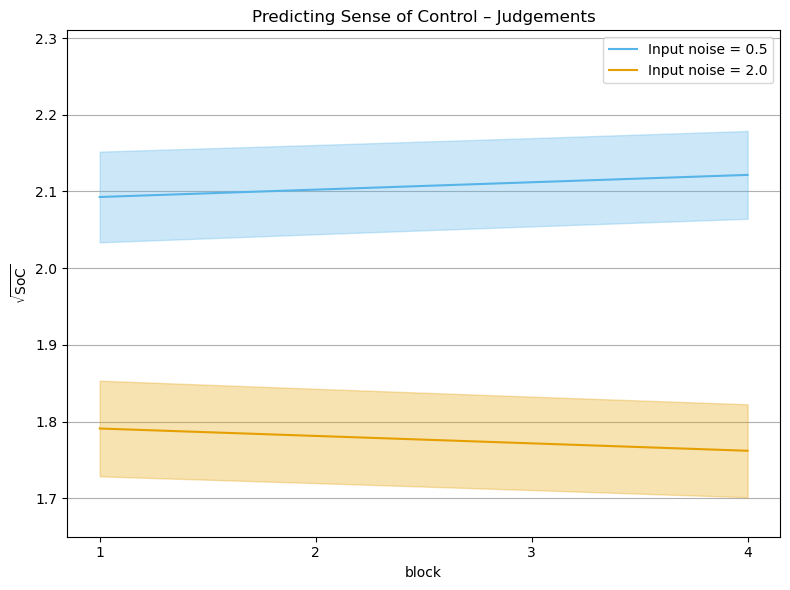

In [17]:
# only rows where feedback == "neutral" (baseline)
# ensures that we are isolating the input_noise_magnitude × block interaction
pred_plot = pred_df[pred_df["feedback"] == "neutral"]

# separate predictions by input_noise_magnitude
pred_1 = pred_plot[pred_plot["input_noise_magnitude"] == 0.5]
pred_2 = pred_plot[pred_plot["input_noise_magnitude"] == 2.0]

# x ranges for blocks
x_range_1 = np.linspace(1, 4, 100)
x_range_2 = np.linspace(1, 4, 100)

# interpolation for noise = 0.5
fit_interp_1 = interp1d(pred_1["block"], pred_1["fit"], kind='linear', fill_value="extrapolate")
lower_interp_1 = interp1d(pred_1["block"], pred_1["lower"], kind='linear', fill_value="extrapolate")
upper_interp_1 = interp1d(pred_1["block"], pred_1["upper"], kind='linear', fill_value="extrapolate")

y_range_1 = fit_interp_1(x_range_1)
lower_range_1 = lower_interp_1(x_range_1)
upper_range_1 = upper_interp_1(x_range_1)

# interpolation for noise = 2.0
fit_interp_2 = interp1d(pred_2["block"], pred_2["fit"], kind='linear', fill_value="extrapolate")
lower_interp_2 = interp1d(pred_2["block"], pred_2["lower"], kind='linear', fill_value="extrapolate")
upper_interp_2 = interp1d(pred_2["block"], pred_2["upper"], kind='linear', fill_value="extrapolate")

y_range_2 = fit_interp_2(x_range_2)
lower_range_2 = lower_interp_2(x_range_2)
upper_range_2 = upper_interp_2(x_range_2)

plt.rcParams['axes.axisbelow'] = True
plt.figure(figsize=(8, 6))
plt.grid(axis='y')

# input noise = 0.5
plt.plot(x_range_1, y_range_1, color="#56B4E9", linestyle='-', label="Input noise = 0.5")
plt.fill_between(x_range_1, lower_range_1, upper_range_1, color="#56B4E9", alpha=0.3)

# input noise = 2.0
plt.plot(x_range_2, y_range_2, color="#E69F00", linestyle='-', label="Input noise = 2.0")
plt.fill_between(x_range_2, lower_range_2, upper_range_2, color="#E69F00", alpha=0.3)

plt.xlabel("block")
plt.xticks([1, 2, 3, 4])
plt.ylim([1.65, 2.31])
plt.ylabel(r'$\sqrt{\mathrm{SoC}}$')
plt.title("Predicting Sense of Control – Judgements")
plt.legend()
plt.tight_layout()

plt.savefig("soc_model_inputnoise_block.svg", dpi=2000)
plt.show()

## positive feedback * block

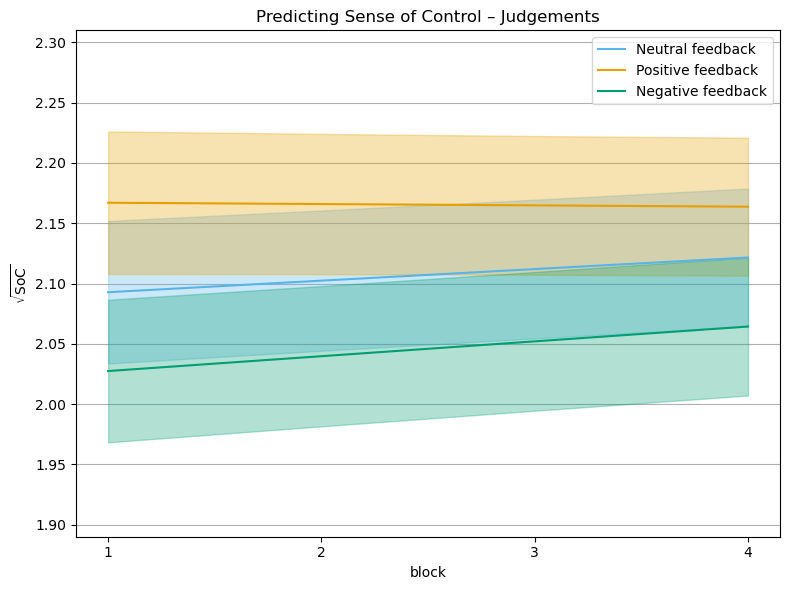

In [18]:
# baseline input_noise_magnitude = 0.5
pred_plot = pred_df[pred_df["input_noise_magnitude"] == 0.5]

# split by feedback level
pred_pos = pred_plot[pred_plot["feedback"] == "positive"]
pred_neg = pred_plot[pred_plot["feedback"] == "negative"]
pred_neu = pred_plot[pred_plot["feedback"] == "neutral"]

# x range for block
x_range = np.linspace(1, 4, 100)

# --- interpolation ---
def interpolate(pred):
    fit = interp1d(pred["block"], pred["fit"], kind='linear', fill_value="extrapolate")
    lower = interp1d(pred["block"], pred["lower"], kind='linear', fill_value="extrapolate")
    upper = interp1d(pred["block"], pred["upper"], kind='linear', fill_value="extrapolate")
    return fit(x_range), lower(x_range), upper(x_range)

y_pos, lower_pos, upper_pos = interpolate(pred_pos)
y_neg, lower_neg, upper_neg = interpolate(pred_neg)
y_neu, lower_neu, upper_neu = interpolate(pred_neu)


plt.rcParams['axes.axisbelow'] = True
plt.figure(figsize=(8, 6))
plt.grid(axis='y')

#009E73 # green
#E69F00 # orange
#56B4E9 # blue

# neutral (baseline)
plt.plot(x_range, y_neu, color="#56B4E9", linestyle='-', label="Neutral feedback")
plt.fill_between(x_range, lower_neu, upper_neu, color="#56B4E9", alpha=0.3)

# positive feedback
plt.plot(x_range, y_pos, color="#E69F00", linestyle='-', label="Positive feedback")
plt.fill_between(x_range, lower_pos, upper_pos, color="#E69F00", alpha=0.3)

# negative feedback
plt.plot(x_range, y_neg, color="#009E73", linestyle='-', label="Negative feedback")
plt.fill_between(x_range, lower_neg, upper_neg, color="#009E73", alpha=0.3)

# neutral (baseline)
#plt.plot(x_range, y_neu, color="#56B4E9", linestyle='-', label="Neutral feedback")
#plt.fill_between(x_range, lower_neu, upper_neu, color="#56B4E9", alpha=0.3)

plt.xlabel("block")
plt.xticks([1, 2, 3, 4])
plt.ylim([1.89, 2.31])
plt.ylabel(r'$\sqrt{\mathrm{SoC}}$')
plt.title("Predicting Sense of Control – Judgements")
plt.legend()
plt.tight_layout()

plt.savefig("soc_model_feedback_block.svg", dpi=2000)
plt.show()

## Input noise magnitude * CESDR

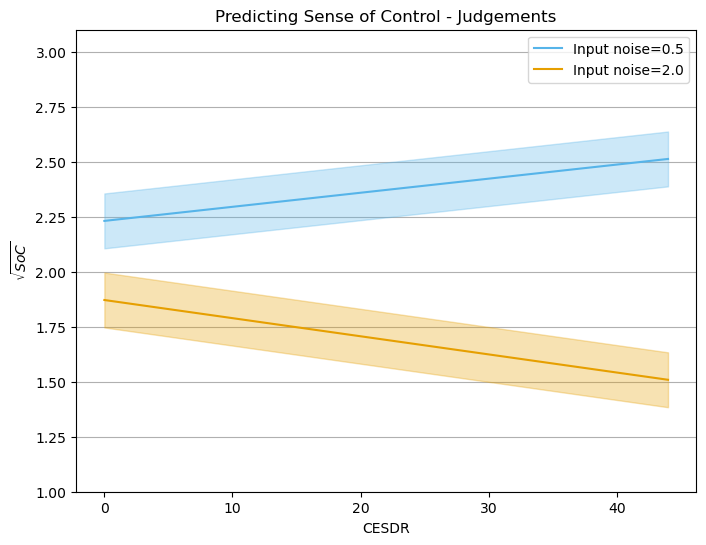

In [19]:
# separate data based on input_noise_magnitude
data_1 = data[data["input_noise_magnitude"] == 0.5]
data_2 = data[data["input_noise_magnitude"] == 2.0]

# define linear model parameters
intercept_1, slope_1, ci_1 = 2.231, 0.0064, 0.1216+0.003126
intercept_2, slope_2, ci_2 = 2.231-0.3596, 0.0064-0.01464, 0.1216+0.003126


plt.rcParams['axes.axisbelow'] = True
plt.figure(figsize=(8, 6))
#plt.grid(True)
plt.grid(axis='y')


# linear models
cesdr_min = min(data["CESDR"].min(), data_1["CESDR"].min(), data_2["CESDR"].min())
cesdr_max = max(data["CESDR"].max(), data_1["CESDR"].max(), data_2["CESDR"].max())
cesdr_range = np.linspace(cesdr_min, cesdr_max, 100)

# input noise:0.5
y_range_1 = intercept_1 + slope_1 * cesdr_range
plt.plot(cesdr_range, y_range_1, color="#56B4E9", linestyle='-', label=f"Input noise=0.5")  # np.exp to reach data point scale
# CI
plt.fill_between(cesdr_range, y_range_1-ci_1, y_range_1+ci_1, color="#56B4E9", alpha=.3)


# input noise:2.0
y_range_2 = intercept_2 + slope_2 * cesdr_range
plt.plot(cesdr_range, y_range_2, color="#E69F00", linestyle='-', label=f"Input noise=2.0")  # np.exp to reach data point scale
# CI
plt.fill_between(cesdr_range, y_range_2-ci_2, y_range_2+ci_2, color="#E69F00", alpha=.3)

# labeling
plt.xlabel("CESDR")
#plt.xticks(np.round(np.linspace(cesdr_min, cesdr_max, 5), 2))
plt.ylim([1.0, 3.1])
#plt.yticks([1, 2, 3])
plt.ylabel(r'$\sqrt{SoC}$')
plt.legend()
plt.title("Predicting Sense of Control - Judgements")

plt.savefig("soc_model_cesdr_inputnoise.svg", dpi=2000)

plt.show()

## Feedback * CESDR

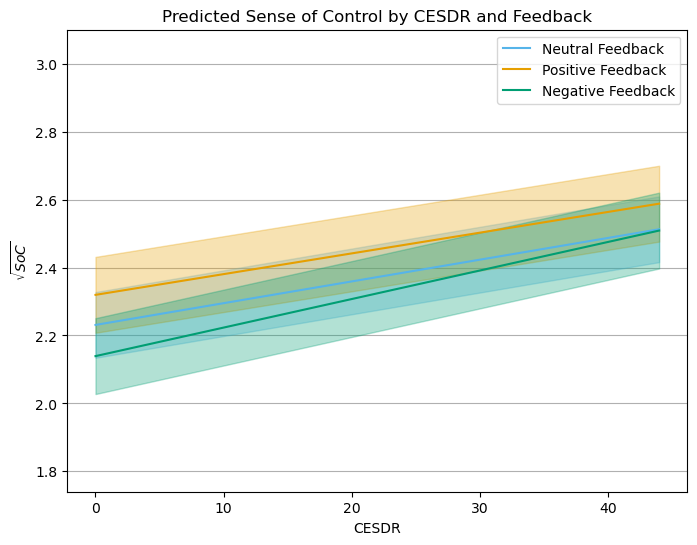

In [22]:
intercept = 2.231
slope = 0.0064

# Coefs
# positive feedback:
intercept_pos = intercept + 0.08853
slope_pos = slope + (-0.0003)
ci_pos = 0.09276+0.00394+0.01495

# negative feedback:
intercept_neg = intercept - 0.09184
slope_neg = slope + 0.002
ci_neg = 0.09276+0.00394+0.01495

# neutral feedback (baseline):
ci_neu = 0.09276+0.00394

# CESDR range
cesdr_min, cesdr_max = data["CESDR"].min(), data["CESDR"].max()
cesdr_range = np.linspace(cesdr_min, cesdr_max, 100)

# predicted values for each feedback condition
y_neu = intercept + slope * cesdr_range
y_pos = intercept_pos + slope_pos * cesdr_range
y_neg = intercept_neg + slope_neg * cesdr_range

plt.figure(figsize=(8,6))
plt.grid(axis='y')
plt.rcParams['axes.axisbelow'] = True

#009E73 # green
#E69F00 # orange
#56B4E9 # blue

# baseline (neutral)
plt.plot(cesdr_range, y_neu, color='#56B4E9', linestyle='-', label='Neutral Feedback')
plt.fill_between(cesdr_range, y_neu - ci_neu, y_neu + ci_neu, color='#56B4E9', alpha=0.3)

# positive feedback
plt.plot(cesdr_range, y_pos, color='#E69F00', linestyle='-', label='Positive Feedback')
plt.fill_between(cesdr_range, y_pos - ci_pos, y_pos + ci_pos, color='#E69F00', alpha=0.3)

# negative feedback
plt.plot(cesdr_range, y_neg, color='#009E73', linestyle='-', label='Negative Feedback')
plt.fill_between(cesdr_range, y_neg - ci_neg, y_neg + ci_neg, color='#009E73', alpha=0.3)

# labeling
plt.xlabel("CESDR")
plt.ylabel(r'$\sqrt{SoC}$')
plt.ylim([1.74, 3.1])
plt.legend()
plt.title("Predicted Sense of Control by CESDR and Feedback")

plt.savefig("soc_model_cesdr_feedback.svg", dpi=2000)

plt.show()


## Input noise magnitude * ExternalLC

In [57]:
np.unique(data.ExternalLC)

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 5. ])

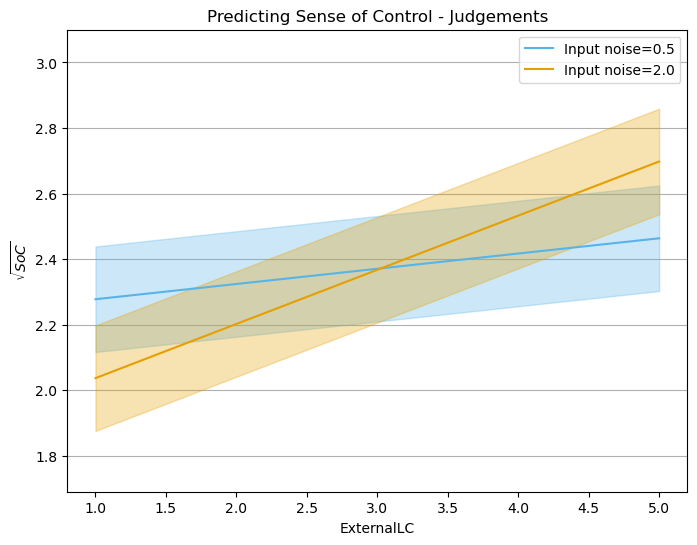

In [21]:
# separate data based on input_noise_magnitude
data_1 = data[data["input_noise_magnitude"] == 0.5]
data_2 = data[data["input_noise_magnitude"] == 2.0]

# define linear model parameters
intercept_1, slope_1, ci_1 = 2.231, 0.04649, 0.1216+0.03940
intercept_2, slope_2, ci_2 = 2.231-0.3596, 0.04649+0.1188, 0.1216+0.03940


plt.rcParams['axes.axisbelow'] = True
plt.figure(figsize=(8, 6))
#plt.grid(True)
plt.grid(axis='y')


# linear models
extlc_min = min(data["ExternalLC"].min(), data_1["ExternalLC"].min(), data_2["ExternalLC"].min())
extlc_max = max(data["ExternalLC"].max(), data_1["ExternalLC"].max(), data_2["ExternalLC"].max())
extlc_range = np.linspace(extlc_min, extlc_max)

# input noise:0.5
y_range_1 = intercept_1 + slope_1 * extlc_range
plt.plot(extlc_range, y_range_1, color="#56B4E9", linestyle='-', label=f"Input noise=0.5")  # np.exp to reach data point scale
# CI
plt.fill_between(extlc_range, y_range_1-ci_1, y_range_1+ci_1, color="#56B4E9", alpha=.3)


# input noise:2.0
y_range_2 = intercept_2 + slope_2 * extlc_range
plt.plot(extlc_range, y_range_2, color="#E69F00", linestyle='-', label=f"Input noise=2.0")  # np.exp to reach data point scale
# CI
plt.fill_between(extlc_range, y_range_2-ci_2, y_range_2+ci_2, color="#E69F00", alpha=.3)

# Labeling
plt.xlabel("ExternalLC")
#plt.xticks(np.round(np.linspace(cesdr_min, cesdr_max, 5), 2))
plt.ylim([1.69, 3.1])
#plt.yticks([1, 2, 3])
plt.ylabel(r'$\sqrt{SoC}$')
plt.legend()
plt.title("Predicting Sense of Control - Judgements")

plt.savefig("soc_model_externalLC_inputnoise.svg", dpi=2000)

plt.show()